In [ ]:
import torch # Основная библиотека для работы с тензорами и нейронными сетями
import numpy as np # Для численных операций и работы с массивами
import matplotlib.pyplot as plt # Для визуализации изображений, масок и графиков
import torchvision.transforms.v2 as T # Современная версия набора трансформаций из torchvision
from google.colab import drive # Импорт функции для монтирования Google Диска
drive.mount('/content/drive') # Подключение Google Диск как папку в Colab
from torchvision.datasets import OxfordIIITPet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)  # должно вывести 'cuda' если GPU подключён

cuda


In [ ]:

# Oxford-IIIT Pet — датасет с 37 классами пород домашних животных (кошки и собаки)
# Cодержит: изображения питомцев, метки классов, маски сегментации для питомцев (если нужно для сегментации)
dataset = OxfordIIITPet('/content/drive/MyDrive/NN_labs/lab_5/dataset', download=True, target_types="segmentation")
# dataset = OxfordIIITPet('/content/drive/MyDrive/NN_labs/lab_5/dataset', target_types="segmentation")
# target_types="segmentation" - Обязательно! иначе вернёт просто метку класса

# Проверить количество элементов и структуру датасета:
print("Всего изображений:", len(dataset))
print("Тип возвращаемого объекта:", type(dataset[0]))

100%|██████████| 792M/792M [00:32<00:00, 24.1MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 11.4MB/s]


Всего изображений: 3680
Тип возвращаемого объекта: <class 'tuple'>


In [ ]:
# Первый элемент датасета
dataset[0]
# Возвращает кортеж (изображение, маска)
#    - dataset[0][0] — PIL.Image с фотографией питомца
#    - dataset[0][1] — PIL.Image с маской сегментации (разметка объекта на фото)

(<PIL.Image.Image image mode=RGB size=394x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=394x500>)

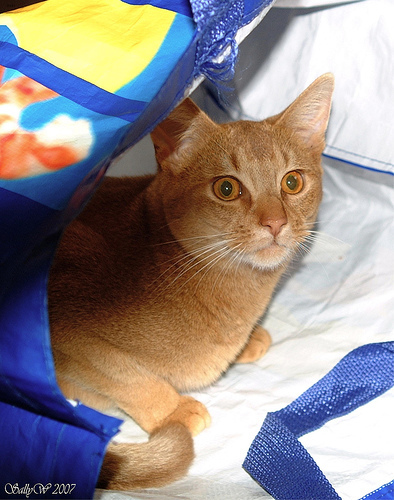

In [ ]:
# Выведем само изображение питомца
# Это обычное RGB-изображение в формате PIL (цветное фото котика)
dataset[0][0]

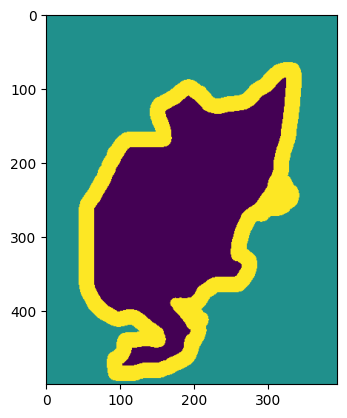

In [ ]:
# Визуализация маски сегментации
plt.imshow(dataset[0][1])

In [ ]:
np.unique(np.array(dataset[0][1]))
# Эта команда покажет, какие численные значения есть в маске

array([1, 2, 3], dtype=uint8)

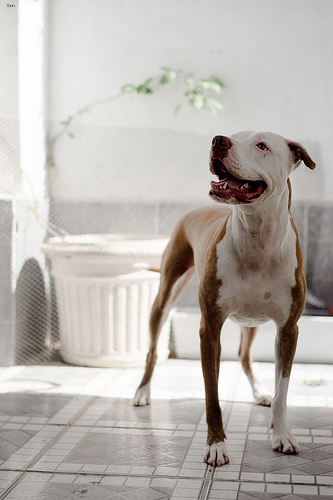

In [ ]:
# Аналогично посмотрим для песика :)
dataset[100][0]

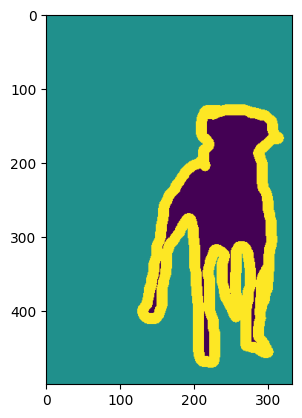

In [ ]:
# Визуализация маски сегментации для песика
plt.imshow(dataset[100][1])

In [ ]:
# Создание преобразования для входных изображений
transform = T.Compose([
    # Изменение размера каждого изображения до 128x128 пикселей
    # Это необходимо, чтобы все входные данные имели одинаковый размер
    T.Resize((128, 128)),
    # Преобразование изображения из формата PIL (обычная картинка) в тензор PyTorch с диапазоном значений [0, 1] и формой (C, H, W)
    T.ToTensor(),
])

# Создание преобразования для целевых меток (масок сегментации)
target_transform = T.Compose([
    # Аналогично, изменяем размер маски до 128x128 пикселей, чтобы размер маски соответствовал размеру изображения
    T.Resize((128, 128)),
    # Преобразование PIL-изображения маски в тензор (значения от 0 до 255)
    # Маска — это не RGB, а одномерное изображение, где каждый пиксель хранит класс
    T.PILToTensor(),

    # Преобразуем маску: вычитаем 1, чтобы классы начинались с 0 (а не с 1) и явно указываем, что это целочисленные значения классов (long) (это важно для функции потерь CrossEntropyLoss)
    T.Lambda(lambda x: (x - 1).long())
])

# Загрузка обучающей части датасета Oxford-IIIT Pet
train_dataset = OxfordIIITPet(
    root='/content/drive/MyDrive/NN_labs/lab_5/dataset', # путь к данным
    download=True,
    transform=transform, # применяем преобразования к изображениям
    target_transform=target_transform, # применяем преобразования к маскам
    target_types='segmentation' # используем маски (а не метки классов)
)

# Загрузка тестовой части датасета (раздел 'test')
valid_dataset = OxfordIIITPet(
    root='/content/drive/MyDrive/NN_labs/lab_5/dataset',  # тот же путь
    download=True,
    split='test', # указываем, что это тестовая выборка
    transform=transform, # те же преобразования изображений
    target_transform=target_transform, # те же преобразования масок
    target_types='segmentation' # тип цели — сегментация
)

/usr/local/lib/python3.12/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
# Импортируем класс DataLoader для построчной загрузки данных (батчами)
from torch.utils.data import DataLoader

# DataLoader для обучающей выборки
train_loader = DataLoader(
    train_dataset, # источник данных — наш train_dataset
    batch_size=64, # размер одного батча (группы изображений) — 64, то есть за один шаг обучения сеть обрабатывает 64 изображения одновременно
    shuffle=True, # перемешиваем данные перед каждой эпохой, чтобы обучение было более устойчивым
    num_workers=8 # количество потоков для параллельной загрузки данных (ускоряет загрузку на многопроцессорных системах)
)

# DataLoader для валидационной (тестовой) выборки
valid_loader = DataLoader(
    valid_dataset, # источник данных — valid_dataset
    batch_size=64, # тот же размер батча
    shuffle=False, # не перемешиваем данные — для теста важно фиксированное соответствие
    num_workers=8 # используем те же 8 потоков
)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch.nn as nn # Базовые слои и функции PyTorch
from torch.utils.data import DataLoader # Для загрузки батчей данных
from torch.optim import Optimizer # Базовый класс для всех оптимизаторов
from tqdm import tqdm # Прогресс-бар для отслеживания обучения

# Функция выполняет один проход обучения (одну эпоху) по всем батчам данных.
def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn, device: torch.device):
    model.train()  # Переводим модель в режим обучения (включаются Dropout, BatchNorm и т.д.)

    total_loss = 0  # Накопитель общей ошибки за эпоху
    total = 0       # Общее количество пикселей (для точности)
    correct = 0     # Количество правильно предсказанных пикселей

    # tqdm(data_loader) — позволяет видеть красивый прогресс-бар во время обучения
    for x, y in tqdm(data_loader):
        bs = y.size(0)  # Размер батча (количество изображений)
        # Переносим данные на GPU (если доступен)
        # y имеет форму (B, 1, H, W), squeeze(1) убирает лишнюю размерность → (B, H, W)
        x, y = x.to(device), y.squeeze(1).to(device)
        optimizer.zero_grad()  # Обнуляем градиенты перед новым шагом
        # Прямой проход через модель
        # На выходе: предсказание сегментационной карты размером (B, num_classes, H, W)
        output = model(x)
        # Вычисляем ошибку между предсказанной и истинной масками
        loss = loss_fn(output, y)
        # Обратное распространение ошибки
        loss.backward()
        # Накопление значения ошибки для логов
        total_loss += loss.item()
        # Получаем предсказанные классы (argmax по каналам — классу)
        _, y_pred = output.max(dim=1)  # (B, H, W)
        # Считаем количество всех пикселей
        total += y.size(0) * y.size(1) * y.size(2)
        # Сравниваем с правильными метками и суммируем количество совпадений
        correct += (y == y_pred).sum().item()
        # Делаем шаг оптимизации (обновляем веса модели)
        optimizer.step()

    # Возвращаем средний loss и точность по всем пикселям за эпоху
    return total_loss / len(data_loader), correct / total


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


@torch.inference_mode() # Декоратор отключает вычисление градиентов (ускоряет и экономит память)
#  Оценивает качество обученной модели на валидационном наборе данных
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device):
    model.eval()  # Переводим модель в режим "оценки" (выключает dropout, batchnorm фиксируется)

    total_loss = 0  # Накопитель ошибки по всем батчам
    total = 0       # Общее количество пикселей
    correct = 0     # Количество правильно предсказанных пикселей

    # Перебираем все батчи из data_loader
    for x, y in tqdm(data_loader):
        bs = y.size(0)  # Размер текущего батча
        # Переносим изображения и маски на выбранное устройство
        # y имеет форму (B, 1, H, W) → squeeze(1) делает (B, H, W)
        x, y = x.to(device), y.squeeze(1).to(device)
        # Прямой проход через модель (без обратного распространения)
        output = model(x)  # (B, num_classes, H, W)
        # Вычисляем значение функции ошибки
        loss = loss_fn(output, y)
        # Накопление общей ошибки
        total_loss += loss.item()
        # Предсказанная карта классов — выбираем индекс максимального значения по каналу (argmax)
        _, y_pred = output.max(dim=1)  # (B, H, W)
        # Считаем количество всех пикселей
        total += y.size(0) * y.size(1) * y.size(2)
        # Считаем количество правильно предсказанных пикселей
        correct += (y == y_pred).sum().item()

    # Возвращаем средний loss и пиксельную точность (accuracy)
    return total_loss / len(data_loader), correct / total

In [ ]:
import matplotlib.pyplot as plt  # библиотека для построения графиков
import seaborn as sns # библиотека для красивой визуализации

sns.set(style='darkgrid') # применяем стиль графиков: тёмная сетка

def plot_stats(
    train_loss: list[float], # список значений потерь на тренировке по эпохам
    valid_loss: list[float], # список значений потерь на валидации по эпохам
    train_accuracy: list[float], # список точности на тренировке по эпохам
    valid_accuracy: list[float], # список точности на валидации по эпохам
    title: str # заголовок для графиков
):
    # График ошибки (loss)
    plt.figure(figsize=(16, 8)) # создаём окно графика шириной 16 и высотой 8 дюймов
    plt.title(title + ' loss') # заголовок графика
    plt.plot(train_loss, label='Train loss') # линия потерь на тренировке
    plt.plot(valid_loss, label='Valid loss') # линия потерь на валидации
    plt.legend() # показываем легенду с подписями линий
    plt.show() # выводим график

    # График точности (accuracy)
    plt.figure(figsize=(16, 8)) # создаём новое окно графика
    plt.title(title + ' accuracy') # заголовок графика
    plt.plot(train_accuracy, label='Train accuracy')  # линия точности на тренировке
    plt.plot(valid_accuracy, label='Valid accuracy')  # линия точности на валидации
    plt.legend() # показываем легенду
    plt.show() # выводим график


In [ ]:
import numpy as np
from PIL import Image

@torch.inference_mode()  # Отключаем вычисление градиентов для экономии памяти при инференсе
def visualize(model, batch, device):
    # Визуализирует предсказания модели сегментации для батча изображений.
    model.eval()  # Переводим модель в режим оценки
    xs, ys = batch  # Разделяем батч на изображения и маски
    to_pil = T.ToPILImage()  # Трансформация тензора в PIL изображение для визуализации
    for i, (x, y) in enumerate(zip(xs, ys)):  # Итерируемся по изображениям и маскам
        # Предсказание модели
        # x.unsqueeze(0) - добавляем batch dimension (1, C, H, W)
        # .to(device) - переносим на нужное устройство
        # .cpu() - возвращаем предсказание на CPU для обработки
        # .squeeze(0) - убираем batch dimension
        # .max(dim=0)[1] - выбираем индекс класса с максимальной вероятностью
        prediction = model(x.unsqueeze(0).to(device)).cpu().squeeze(0).max(dim=0)[1]
        # Создаем окно с тремя подграфиками
        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')
        # Отображаем оригинальное изображение
        ax[0].imshow(to_pil(x))
        # Отображаем истинную маску сегментации
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        # Отображаем предсказанную маску сегментации
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        # Убираем оси для чистоты изображения
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        # Подписываем каждый подграфик
        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        # Настраиваем расстояние между графиками
        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        # Ограничиваем вывод первыми 10 изображениями из батча
        if i >= 9:
            break

In [ ]:
from IPython.display import clear_output # Для очистки вывода между эпохами

# Главная функция обучения модели с визуализацией и графиками потерь и точности
def fit(model, train_loader, valid_loader, optimizer, loss_fn, device, num_epochs, title):
    # Списки для хранения истории потерь и точности
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    # Создаем итератор для валидационного загрузчика
    valid_iterator = iter(valid_loader)
    # Цикл по эпохам
    for epoch in range(num_epochs):
        # Обучение модели на одной эпохе
        train_loss, train_accuracy = train(model, train_loader, optimizer, loss_fn, device)
        # Оценка модели на валидации
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        # Сохраняем значения потерь и точности
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        # Очищаем предыдущий вывод, чтобы графики не дублировались
        clear_output()

        # Визуализация динамики обучения
        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        # Визуализируем предсказания модели на следующем батче валидации
        # next(valid_iterator) берет следующий батч из валидационного датасета
        visualize(model, next(valid_iterator), device)

In [ ]:
def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Создаём блок UNet из двух последовательных свёрток + BatchNorm + LeakyReLU
    - :param in_channels: количество входных каналов
    - :param out_channels: количество выходных каналов
    - :return: nn.Sequential блок (контейнер с архитектурой НС)
    """
    return nn.Sequential(
    # 1. Свёртка с ядром 3x3, stride=1, padding=1. Преобразует вход с in_channels в out_channels
    nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
    # 2. BatchNorm нормализует значения по каждому каналу для ускорения обучения и стабилизации градиентов
    nn.BatchNorm2d(out_channels),
    # 3. LeakyReLU — функция активации, которая даёт небольшое отрицательное значение для отрицательных входов (slope=0.2)
    nn.LeakyReLU(0.2),
    # 4. Вторая свёртка с тем же количеством каналов
    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
    # 5. BatchNorm для второй свёртки
    nn.BatchNorm2d(out_channels),
    # 6. LeakyReLU для второй свёртки
    nn.LeakyReLU(0.2),
)


class UNET(nn.Module):
    def __init__(self): # Констрруктор U-Net
        super().__init__() # Вызывает конструктор родительского класса nn.Module

        base_channels = 32 # Базовое количество каналов
        # --- Энкодер (downsampling) ---
        # отвечает за извлечение признаков и уменьшение пространственного разрешения изображения
        self.down1 = conv_plus_conv(3, base_channels)  # Вход 3 канала (RGB), выход 32
        self.down2 = conv_plus_conv(base_channels, base_channels * 2) # 32 -> 64
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4) # 64 -> 128
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8) # 128 -> 256
        self.down5 = conv_plus_conv(base_channels * 8, base_channels * 16) # 256 -> 512
        # Каждый блок — это двойная свёртка + BatchNorm + LeakyReLU
        # --- Декодер (upsampling) ---
        # Декодер восстанавливает пространственное разрешение
        # residuals определены далее в следующей функции
        # residuals - «мостики» между энкодером и декодером, которые сохраняют детали и упрощают восстановление изображения на выходе
        self.up1 = conv_plus_conv(base_channels * 2, base_channels) # после конкатенации с residual1
        self.up2 = conv_plus_conv(base_channels * 4, base_channels) # после конкатенации с residual2
        self.up3 = conv_plus_conv(base_channels * 8, base_channels * 2) # после конкатенации с residual3
        self.up4 = conv_plus_conv(base_channels * 16, base_channels * 4) # после конкатенации с residual4
        self.up5 = conv_plus_conv(base_channels * 32, base_channels * 8) # после конкатенации с residual5
        # Каждый блок — это двойная свёртка + BatchNorm + LeakyReLU
        # После конкатенации каналов входное число каналов увеличивается в 2 раза, поэтому in_channels в блоке больше, чем out_channels

        self.bottleneck = conv_plus_conv(base_channels * 16, base_channels * 16) # Боттлнек (латентное пространство)
        # На этом уровне у нас самые компактные признаки (по пространству)
        # Можно делать манипуляции с тензором, например добавлять attention или dense слои

        # Выходной слой: свёртка 1x1 для предсказания классов
        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)
        # Преобразует фичи в классы сегментации (здесь 3 класса)
        # Используется 1x1 свёртка, чтобы "сжать" количество каналов до числа классов

        # Субдискретизация (Downsample)
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        # Применяется между блоками энкодера
        # Уменьшает HxW в 2 раза, сохраняя количество каналов

    def forward(self, x):
        # x.shape = (N, 3, H, W) — входное изображение с 3 каналами (RGB)
        # x — батч изображений, где N — размер батча, 3 — число каналов, H и W — высота и ширина

        # --- Энкодер ---
        residual1 = self.down1(x)   # сохраняем "residual" для скип-коннекта: x.shape: (N, N, 3) -> (N, N, base_channels)
        x = self.downsample(residual1)  # уменьшаем размер в 2 раза: x.shape: (N, N, base_channels) -> (N // 2, N // 2, base_channels)
        # down1 — первый блок U-Net, 2 свёртки + BatchNorm + LeakyReLU
        # residual1 сохраняет выход блока до downsampling для будущей конкатенации в декодере
        # downsample уменьшает размер изображения в 2 раза (H/2 x W/2)

        # То же самое для остальных блоков энкодера
        # Накапливаются residuals (residual1..5) для skip connections
        # Размер постепенно уменьшается (H/2 → H/4 → H/8 → H/16 → H/32), а число каналов увеличивается (32 → 64 → 128 → 256 → 512)
        residual2 = self.down2(x)
        x = self.downsample(residual2)
        residual3 = self.down3(x)
        x = self.downsample(residual3)
        residual4 = self.down4(x)
        x = self.downsample(residual4)
        residual5 = self.down5(x)
        x = self.downsample(residual5)

        # --- Буттлнек ---
        # Центр U-Net, здесь самое сжатое представление
        # Размер H/32 x W/32, число каналов максимальное (base_channels*16)
        # Можно проводить дополнительные операции, но здесь только 2 свёртки через conv_plus_conv
        x = self.bottleneck(x)  # x.shape: (N // 32, N // 32, base_channels * 16) -> (N // 32, N // 32, base_channels * 16)

        # --- Декодер с скип-коннектами ---
        # interpolate — увеличиваем размер в 2 раза (H/32 → H/16)
        # Конкатенируем с соответствующим residual из энкодера (residual5), чтобы сохранить детали высокого разрешения
        # up5 — блок свёрток после конкатенации, уменьшаем число каналов
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual5), dim=1)
        x = self.up5(x)

        # То же самое для остальных слоёв
        # Каждый раз: upsampling → конкатенация с residual → блок свёрток
        # Благодаря skip connections U-Net сохраняет пространственную информацию, которая теряется в энкодере
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual4), dim=1)
        x = self.up4(x)
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual3), dim=1)
        x = self.up3(x)
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual2), dim=1)
        x = self.up2(x)
        x = nn.functional.interpolate(x, scale_factor=2)
        x = torch.cat((x, residual1), dim=1)
        x = self.up1(x)

        # --- Выход ---
        x = self.out(x)  # свёртка 1x1 для предсказания масок
        # уменьшает число каналов до числа классов сегментации (3 для Oxford-IIIT Pet)

        return x

In [ ]:
# Определяем устройство для вычислений: GPU, если доступна CUDA, иначе CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Выводим выбранное устройство
print(device)
# Если доступен GPU, выводим его название
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
# Определяем функцию ошибки для многоклассовой сегментации
# CrossEntropyLoss автоматически применяет softmax к логитам модели
loss_fn = nn.CrossEntropyLoss()

cuda:0
Tesla T4


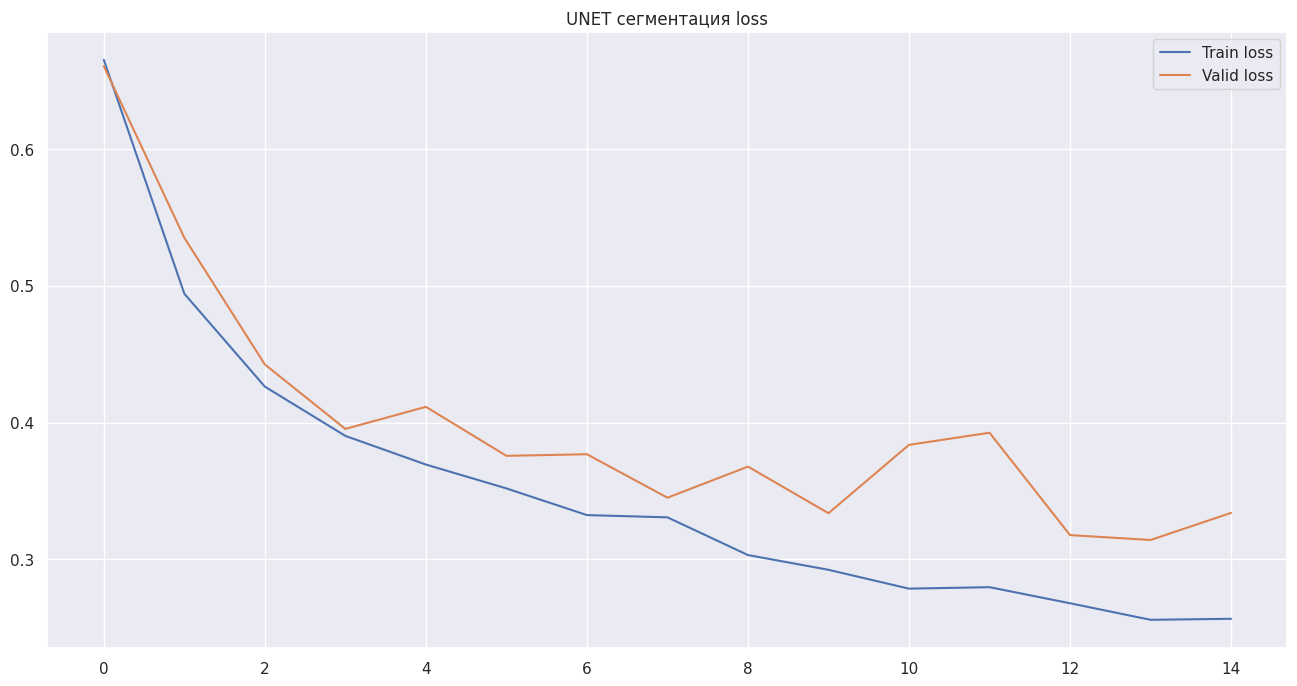

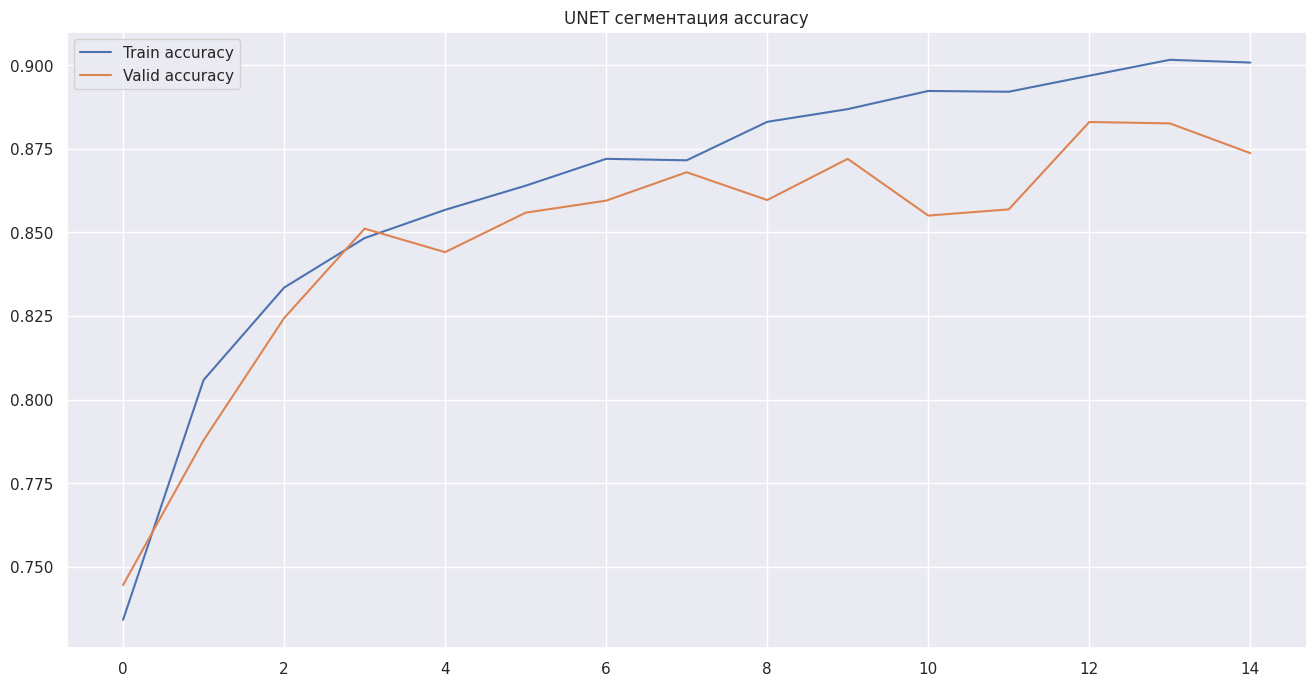

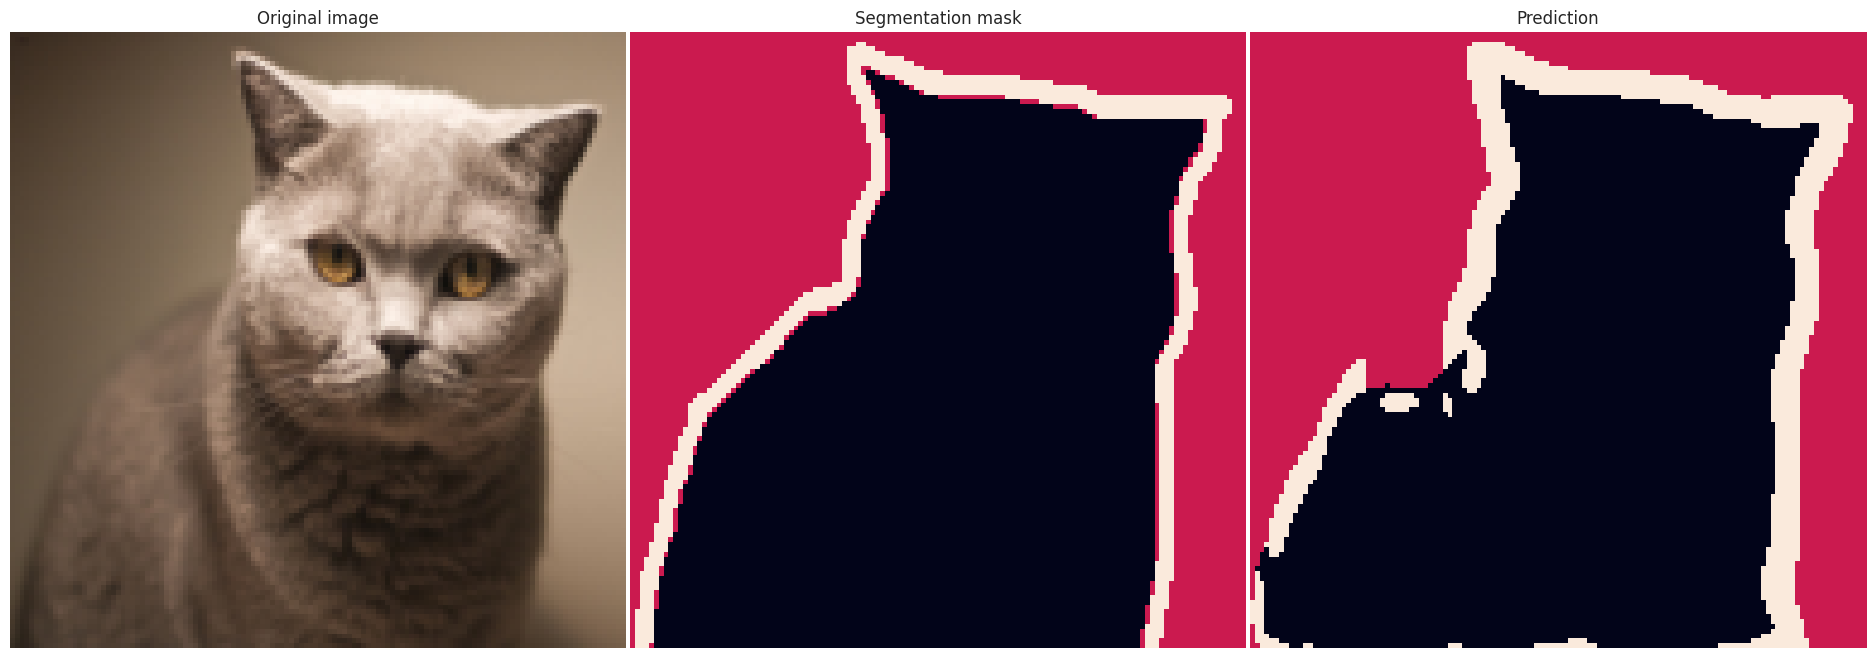

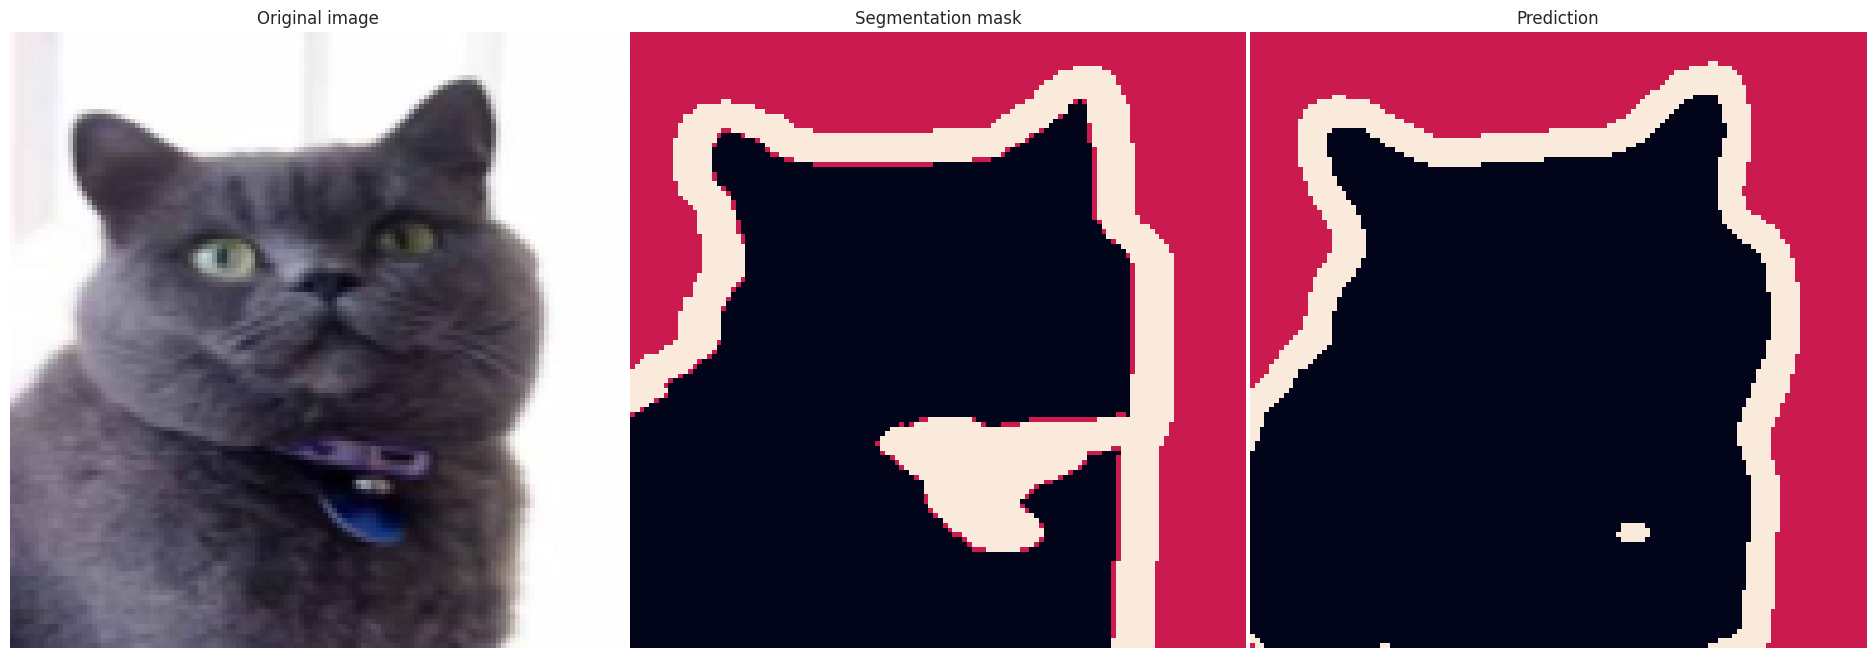

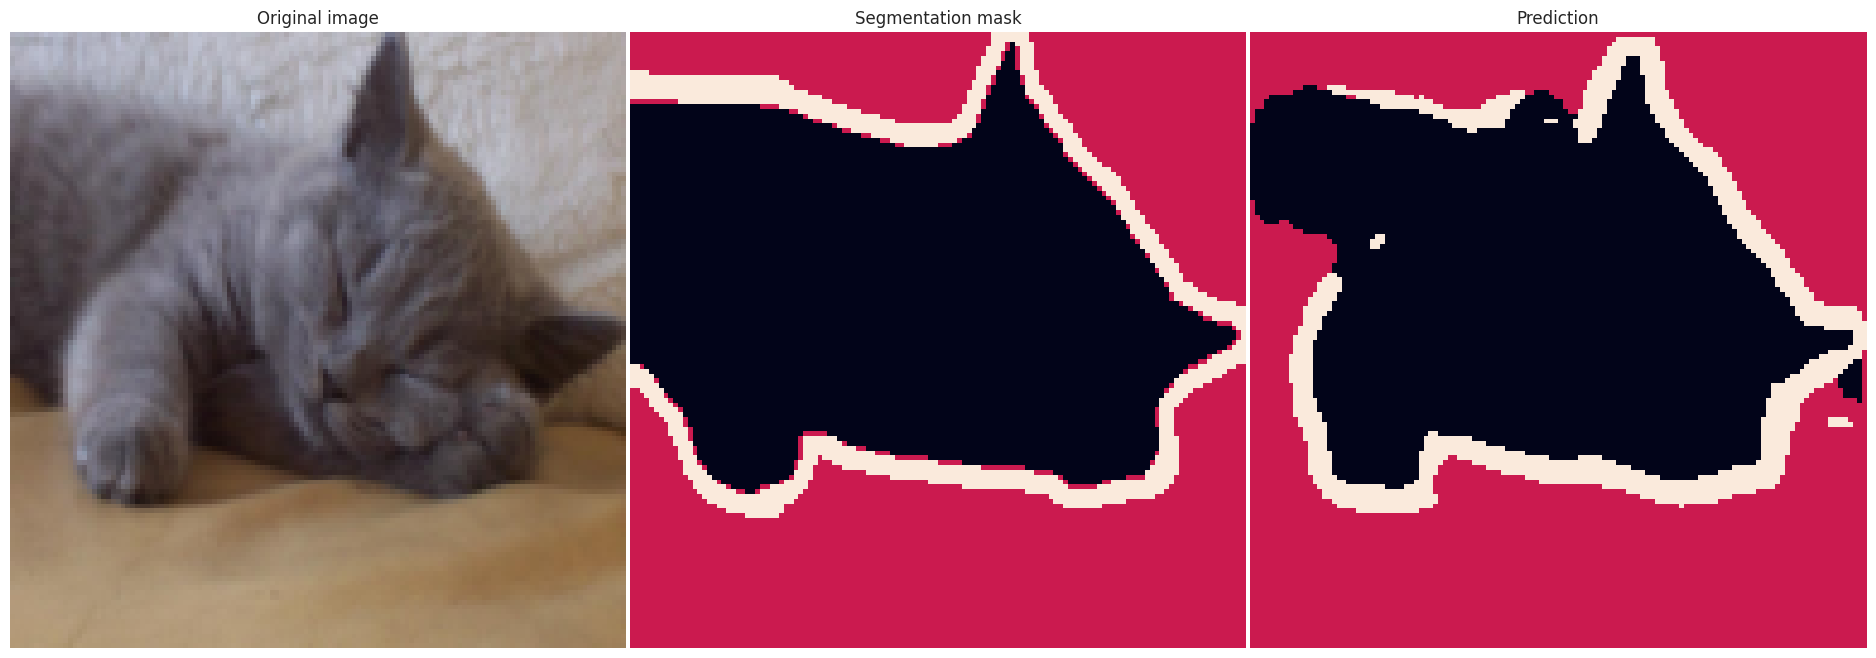

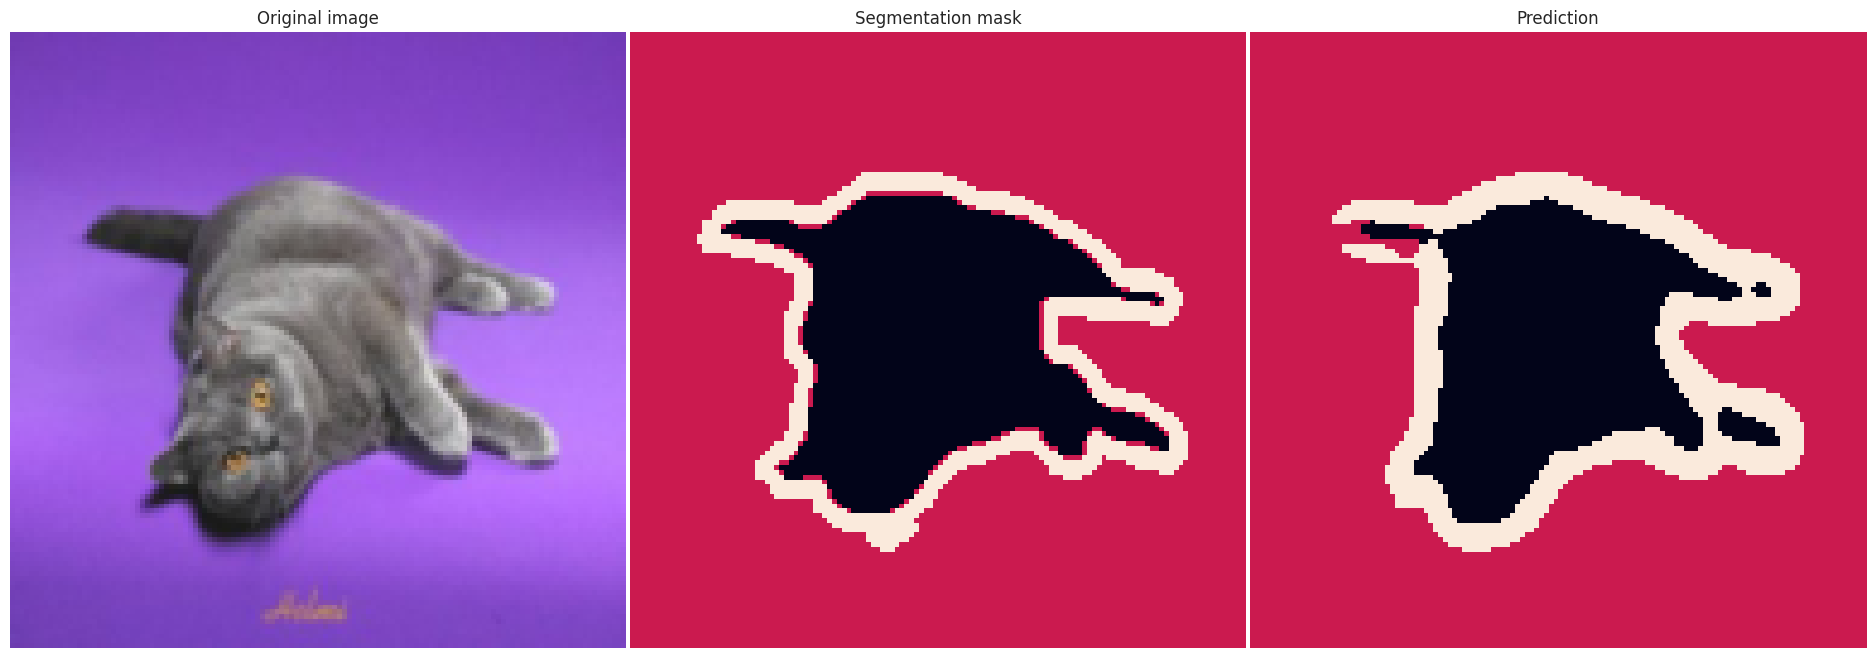

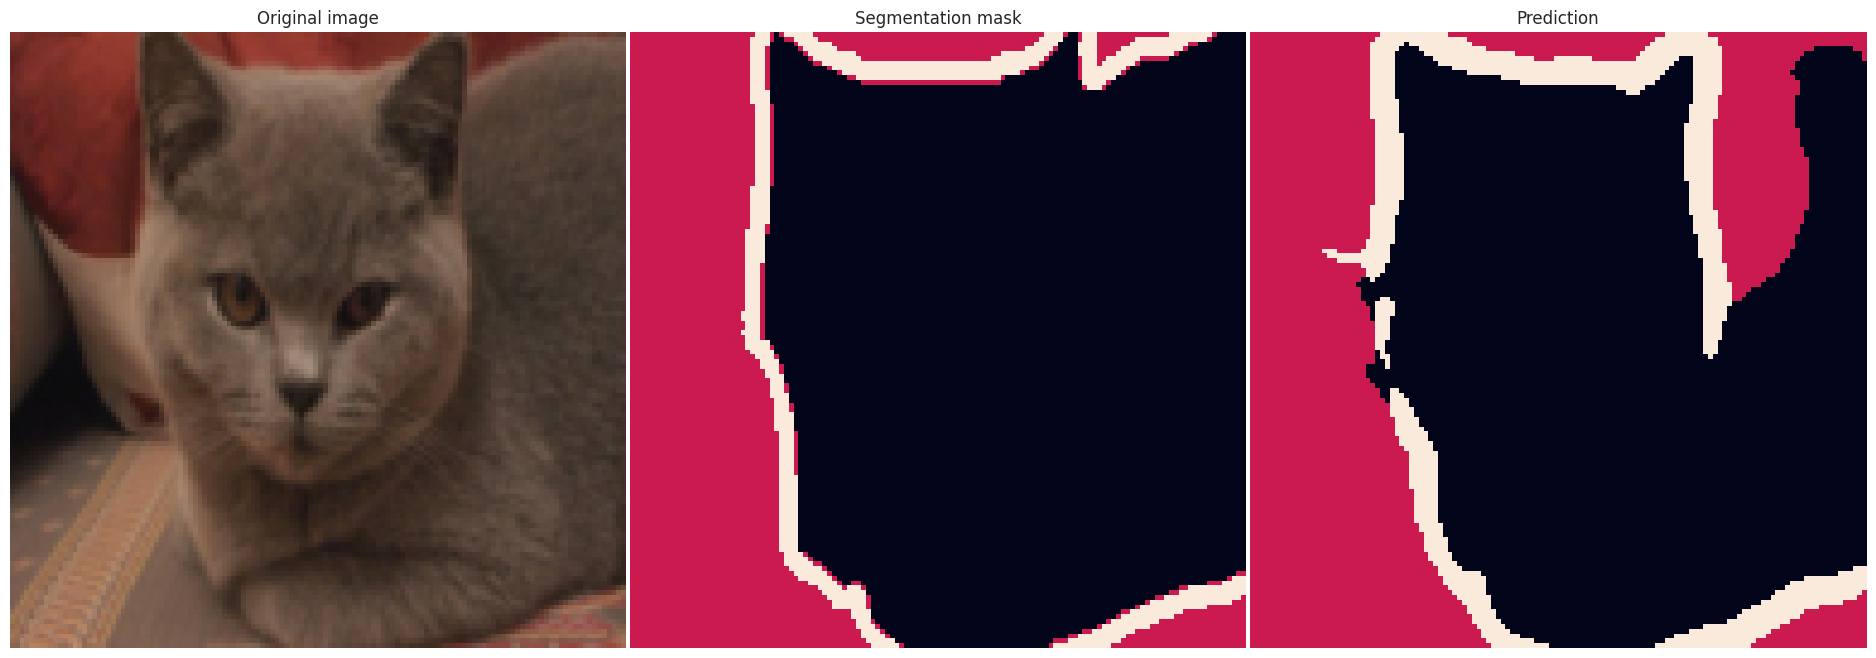

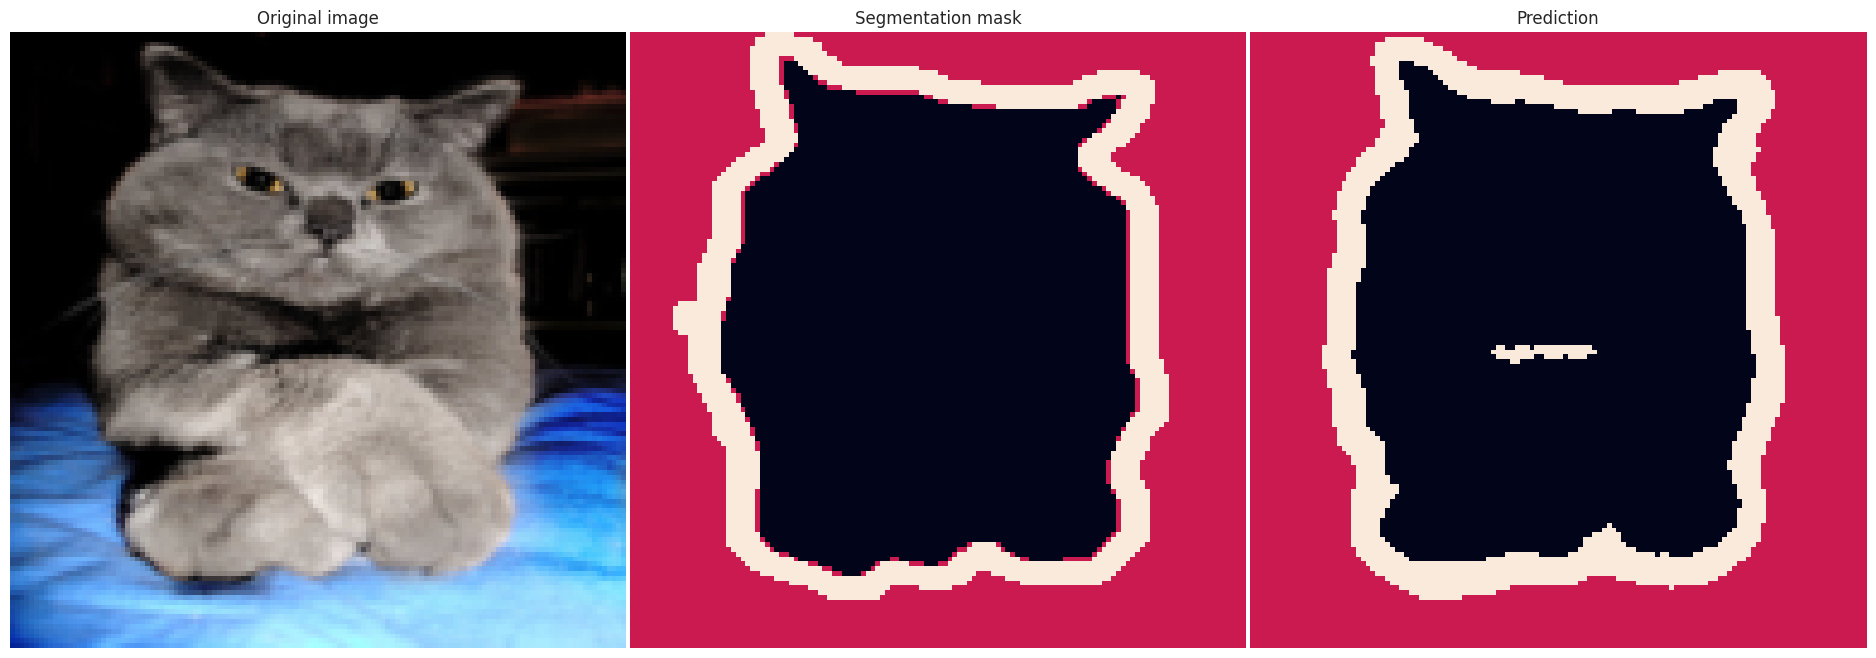

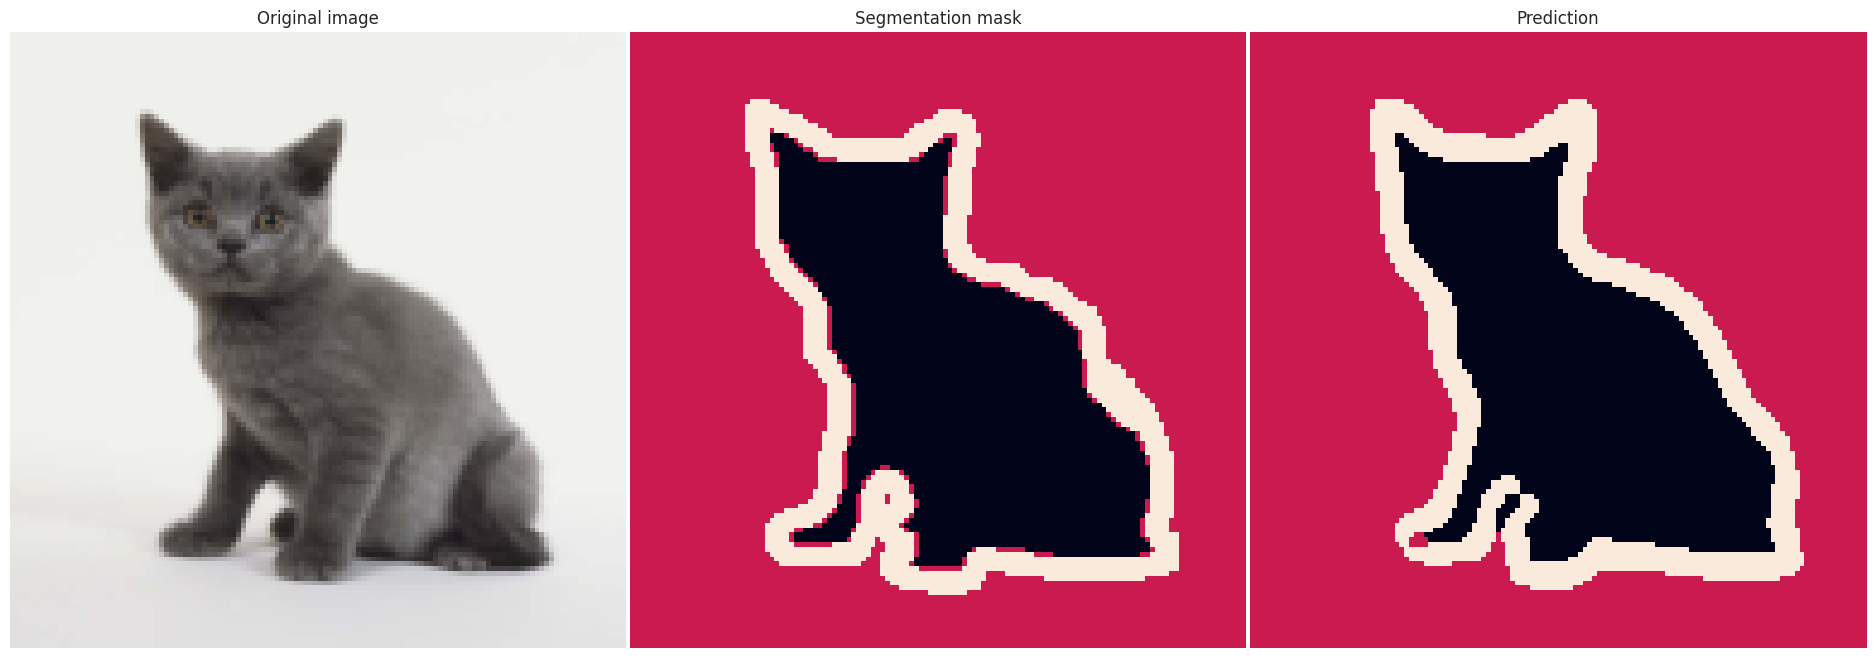

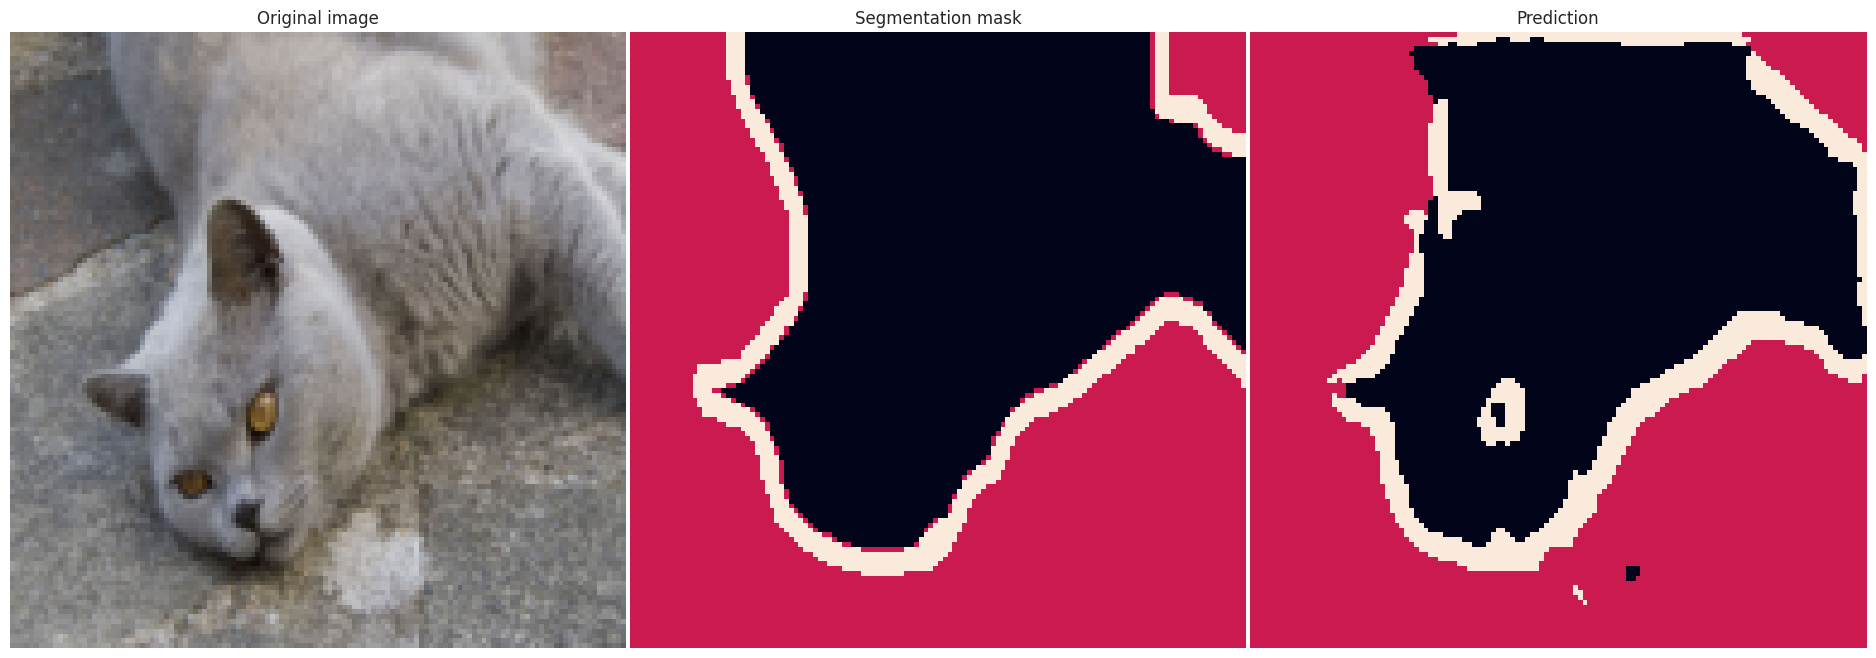

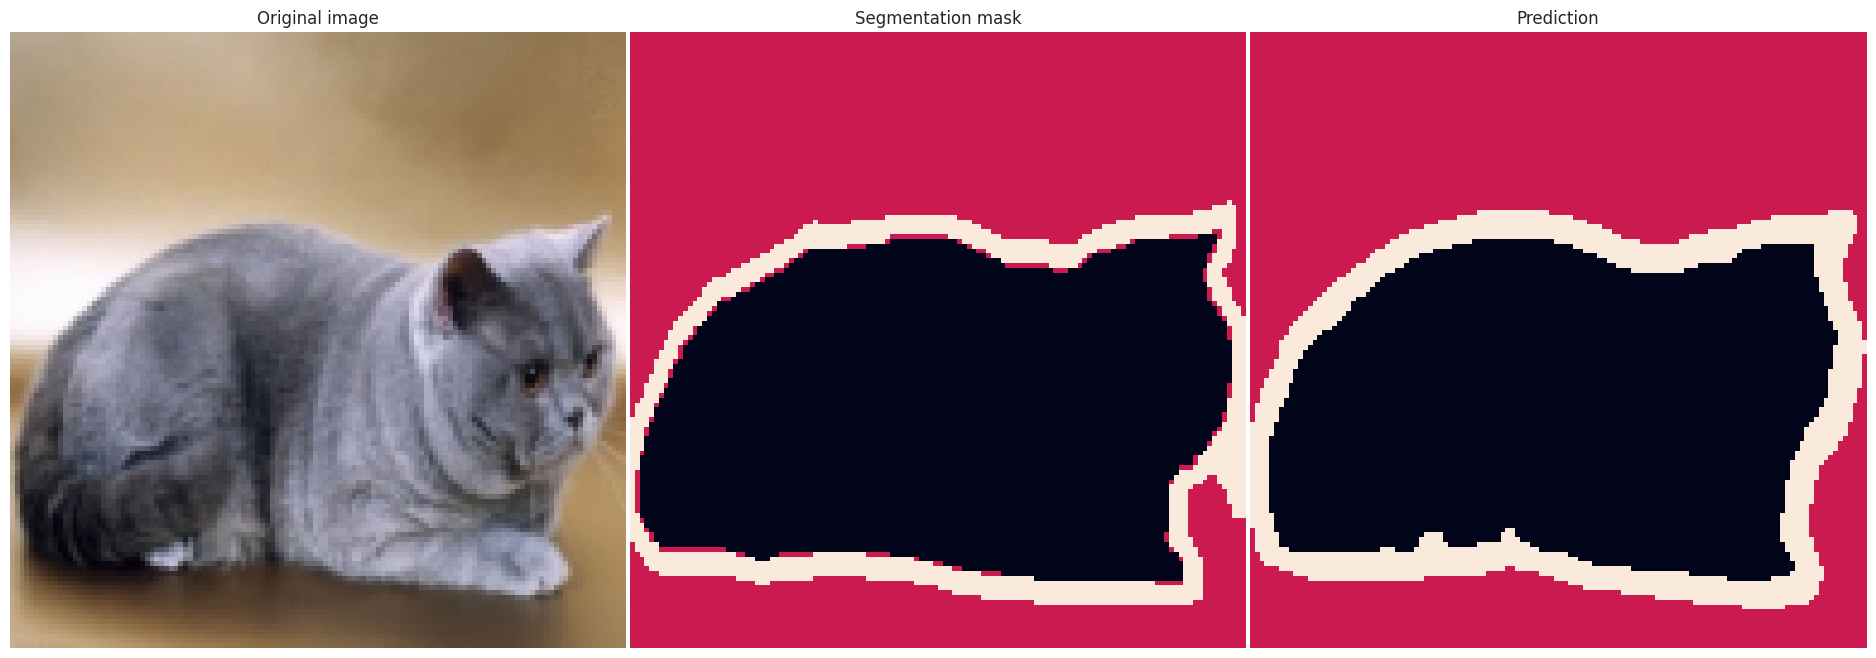

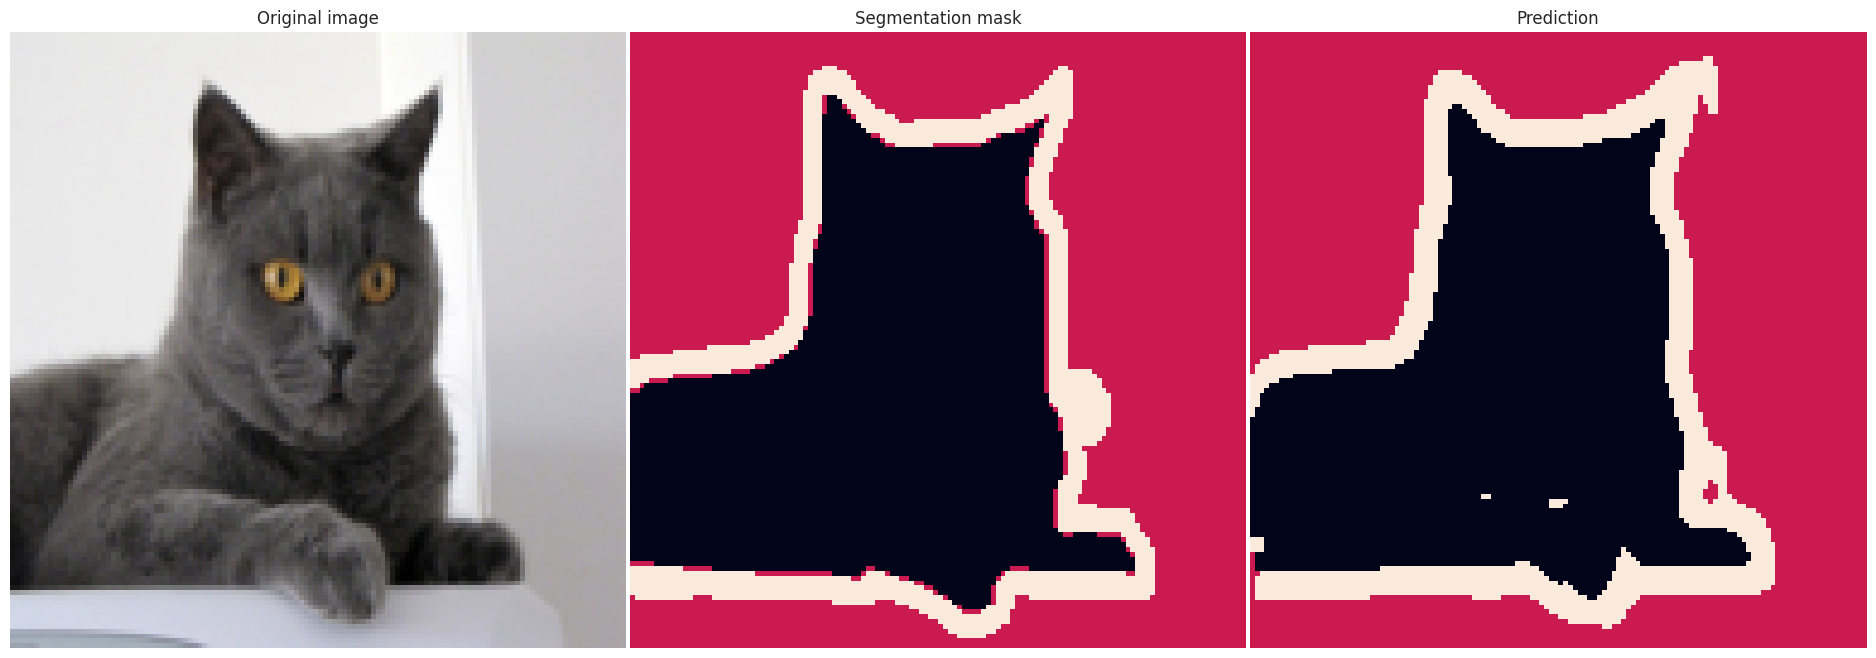

In [ ]:
from torch.optim import Adam  # Импорт оптимизатора Adam

# Создаём экземпляр модели UNET и переносим её на устройство (GPU)
model = UNET().to(device)
# Определяем оптимизатор Adam для обновления всех параметров модели
# learning rate = 0.001
optimizer = Adam(model.parameters(), lr=1e-3)
# Запускаем обучение модели
# train_loader и valid_loader — DataLoader для обучения и валидации
# optimizer — оптимизатор, loss_fn — функция потерь
# device — устройство для вычислений
# 15 — количество эпох обучения
# 'UNET сегментация' — заголовок для графиков потерь и точности
fit(model, train_loader, valid_loader, optimizer, loss_fn, device, 15, 'UNET сегментация')

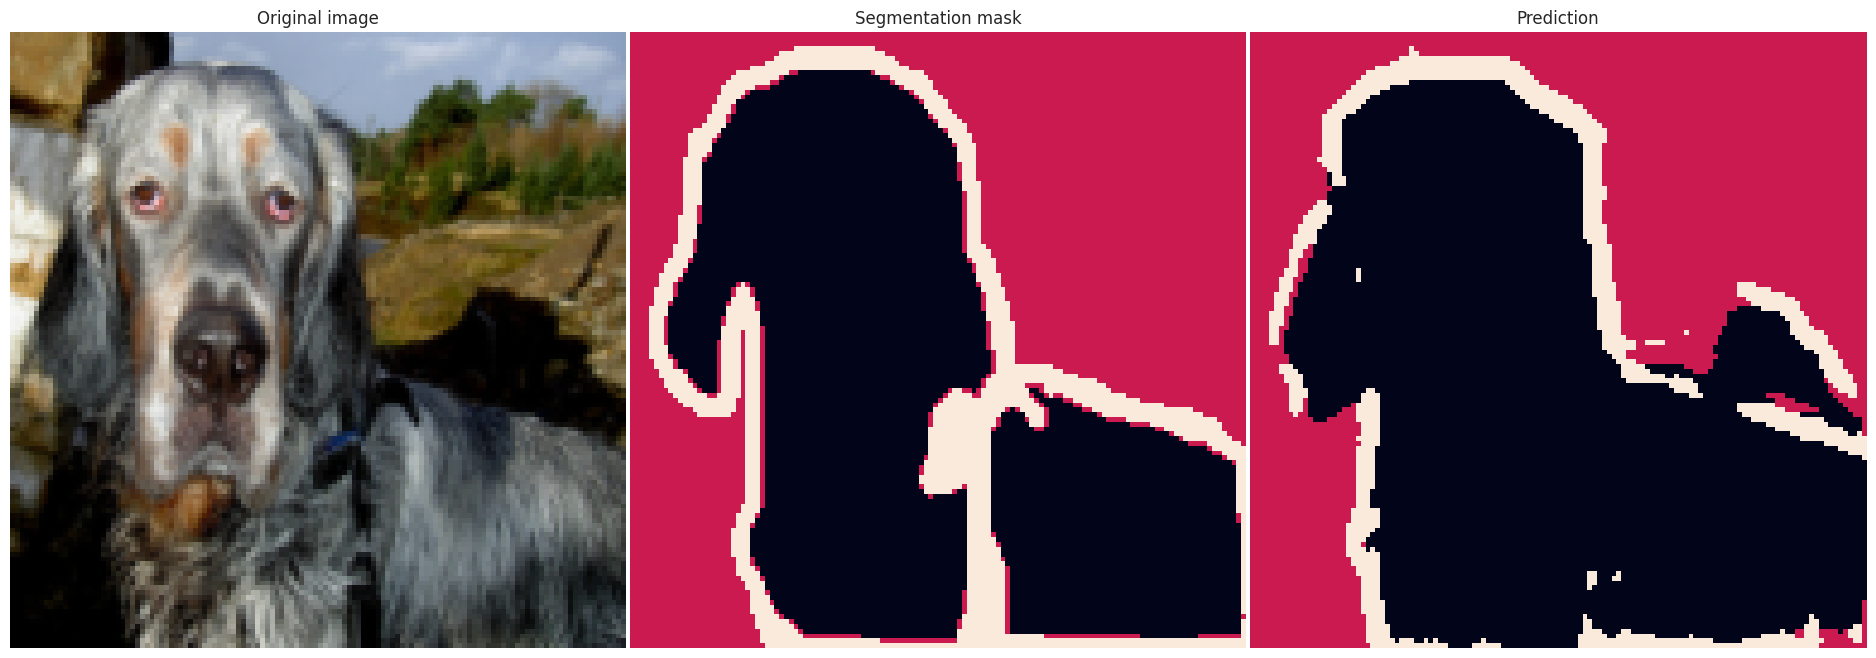

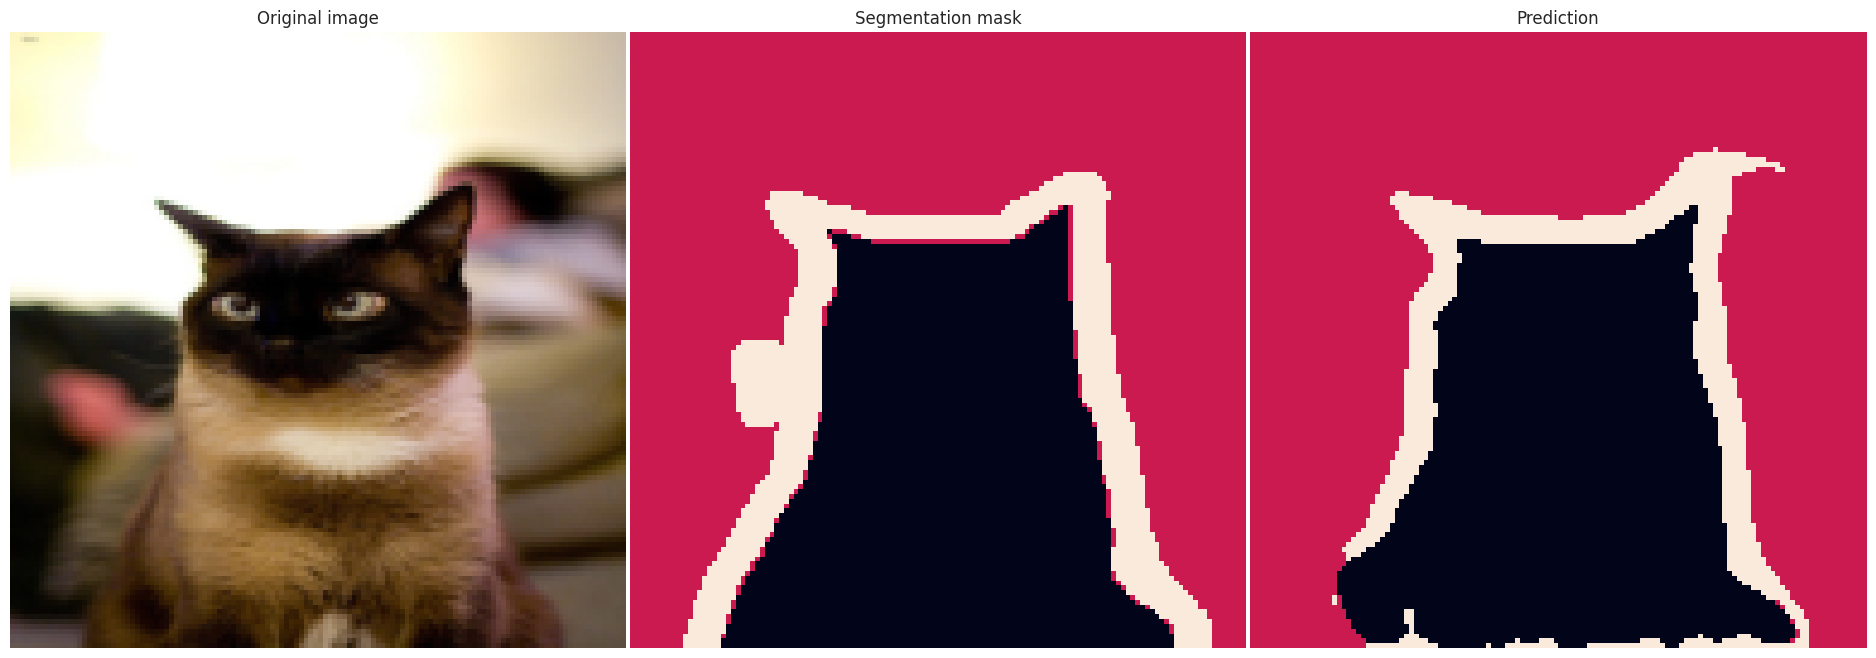

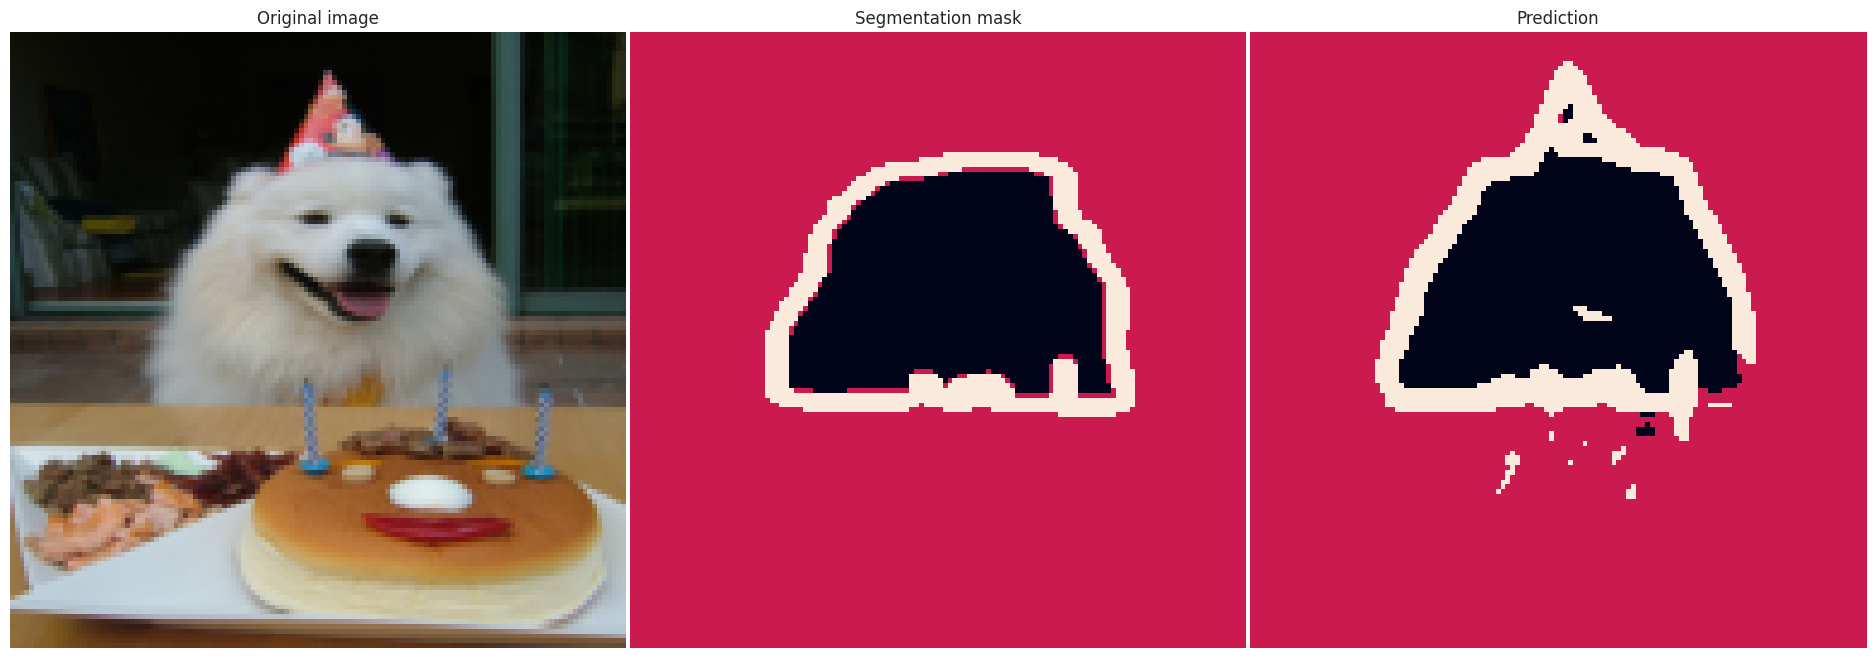

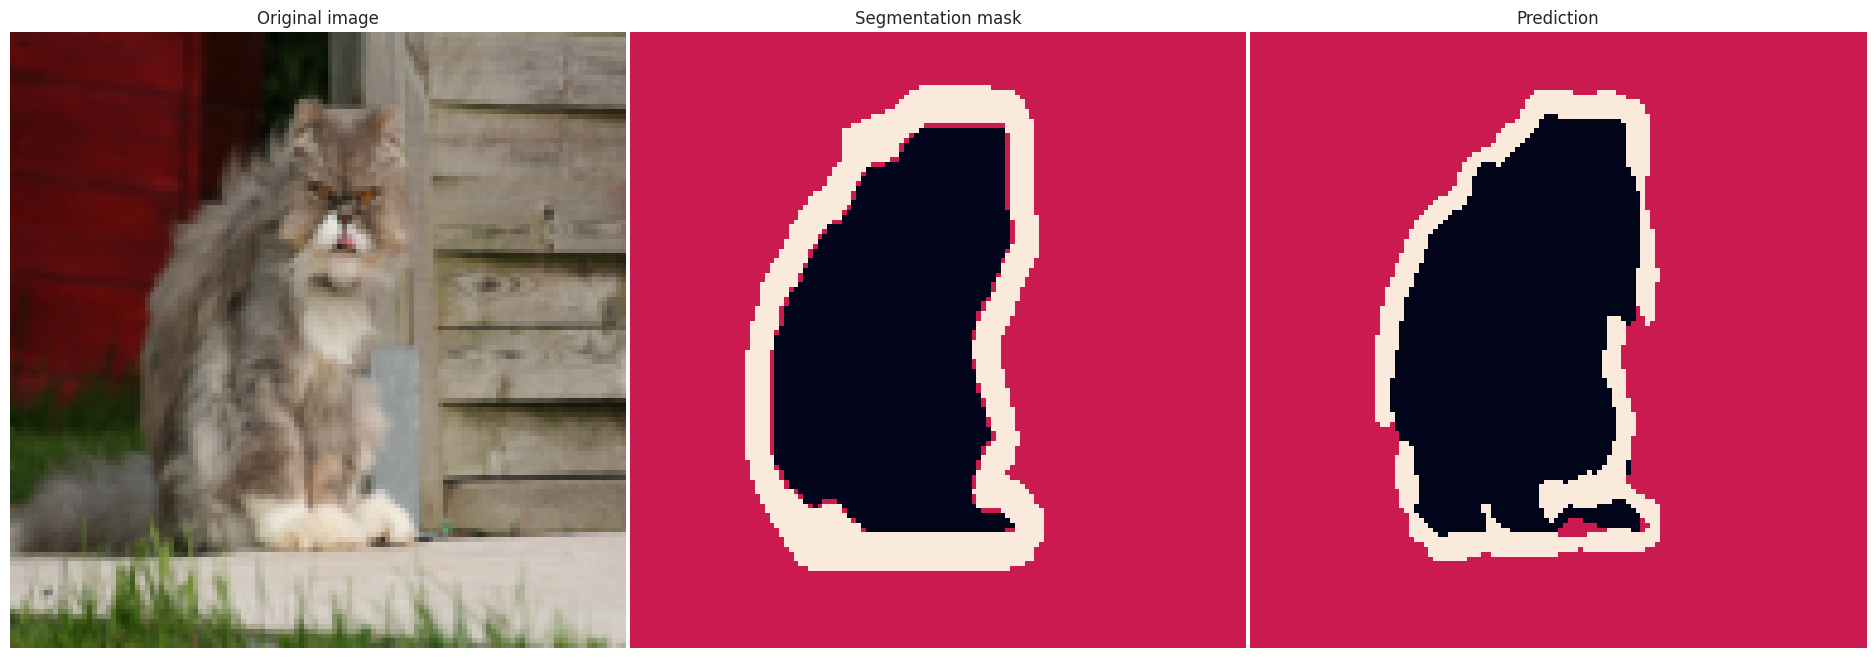

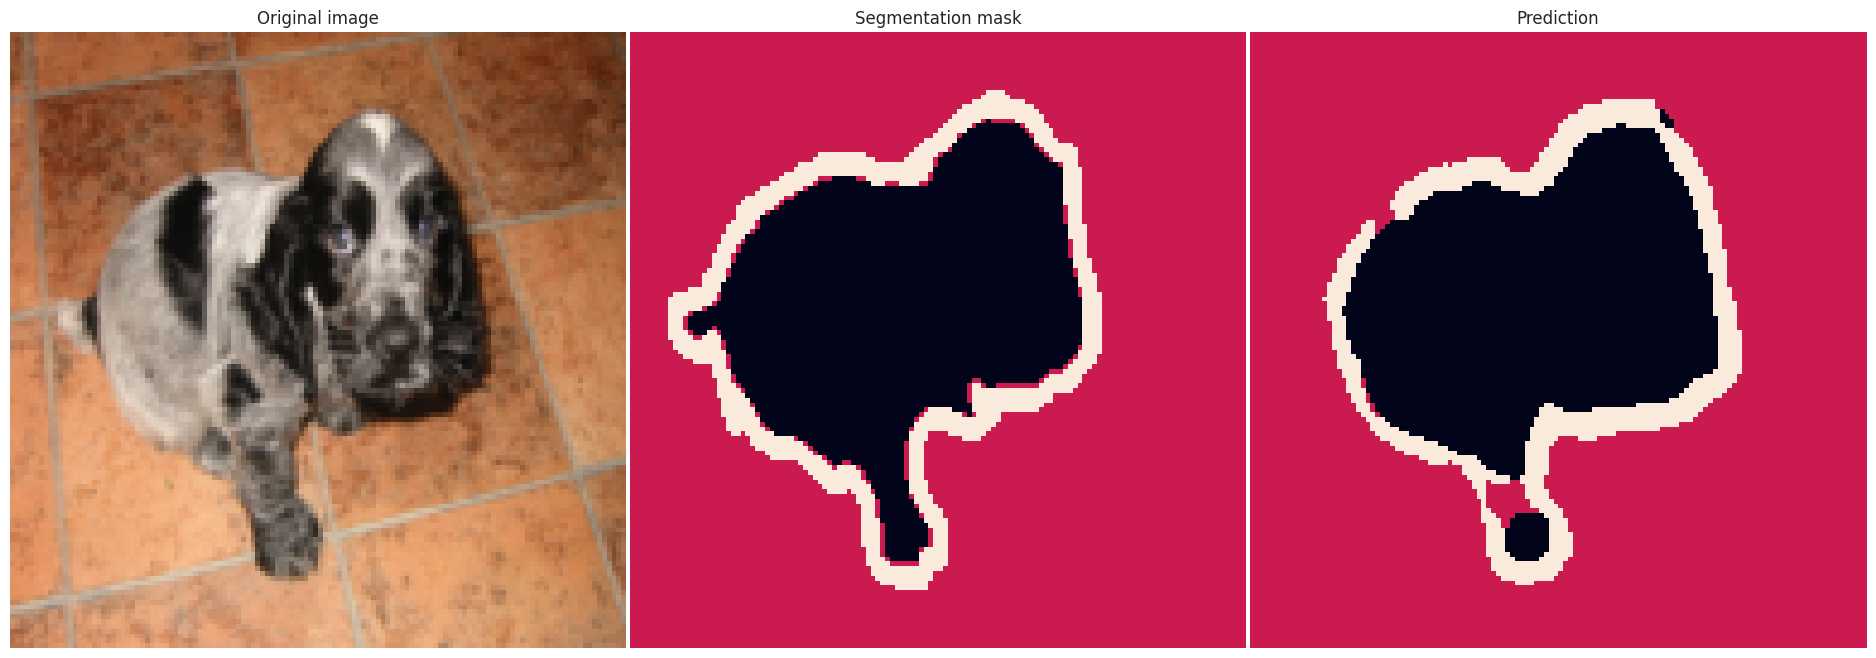

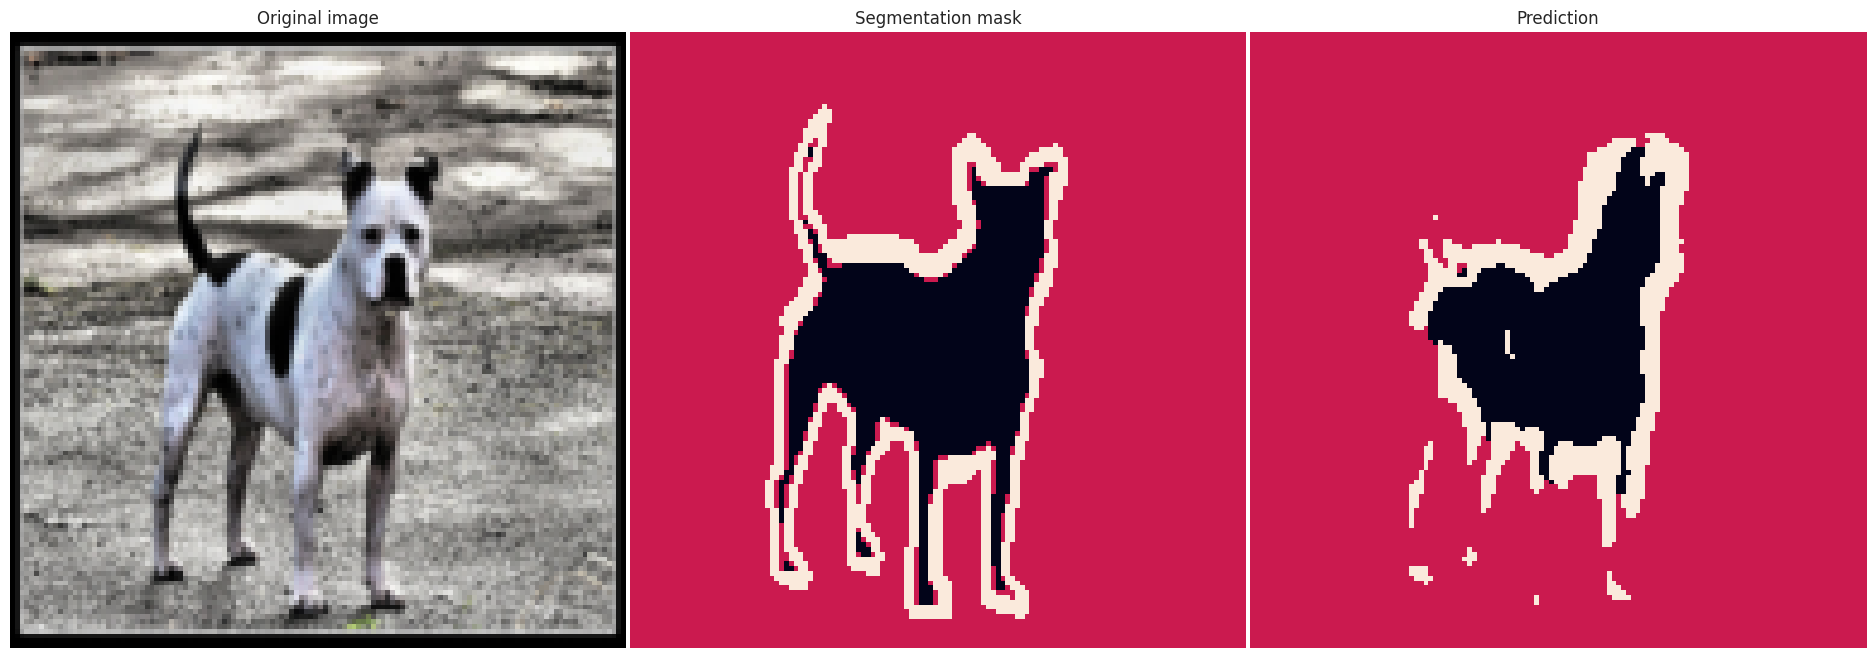

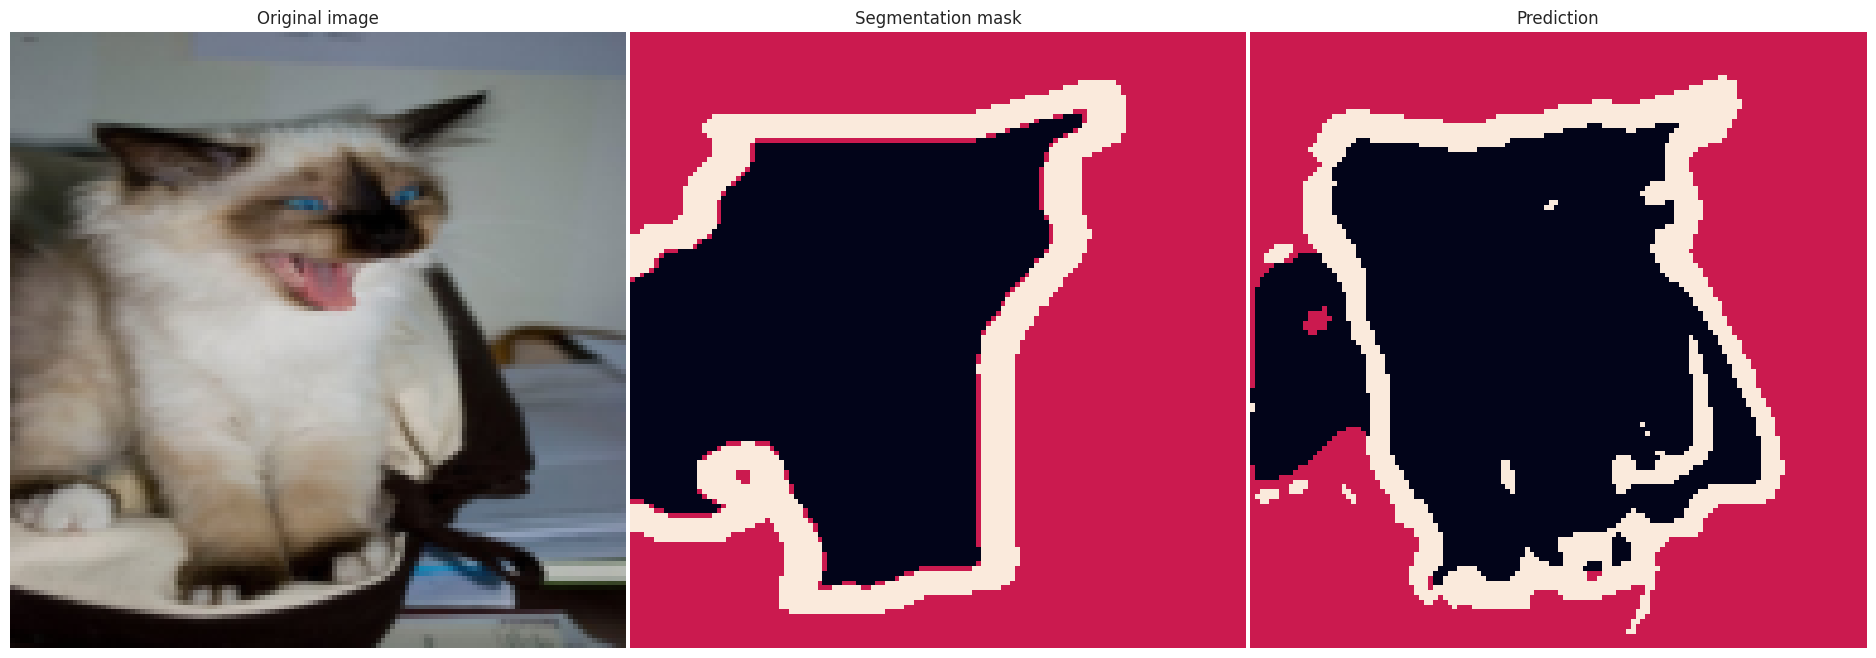

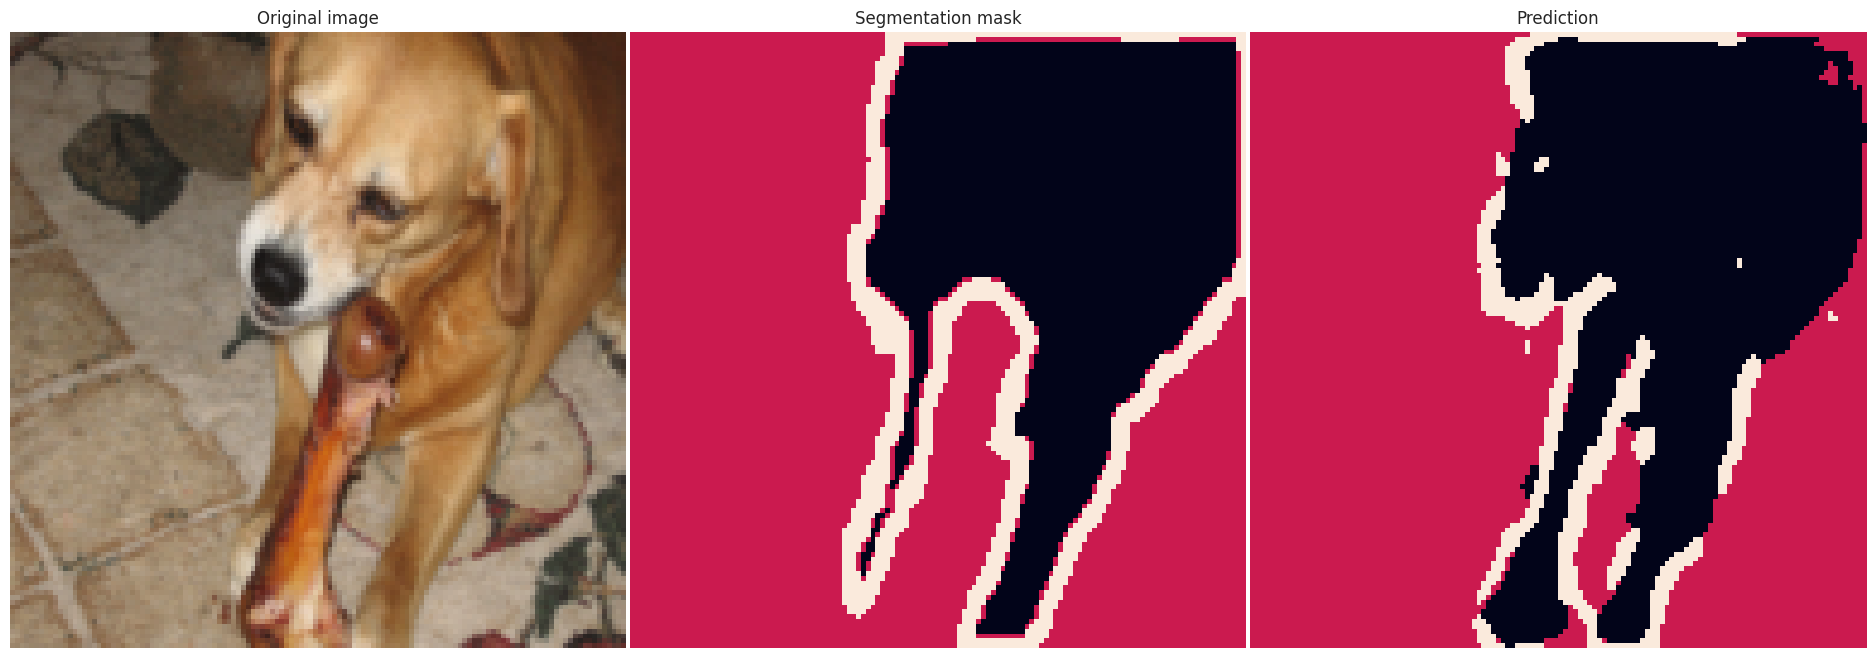

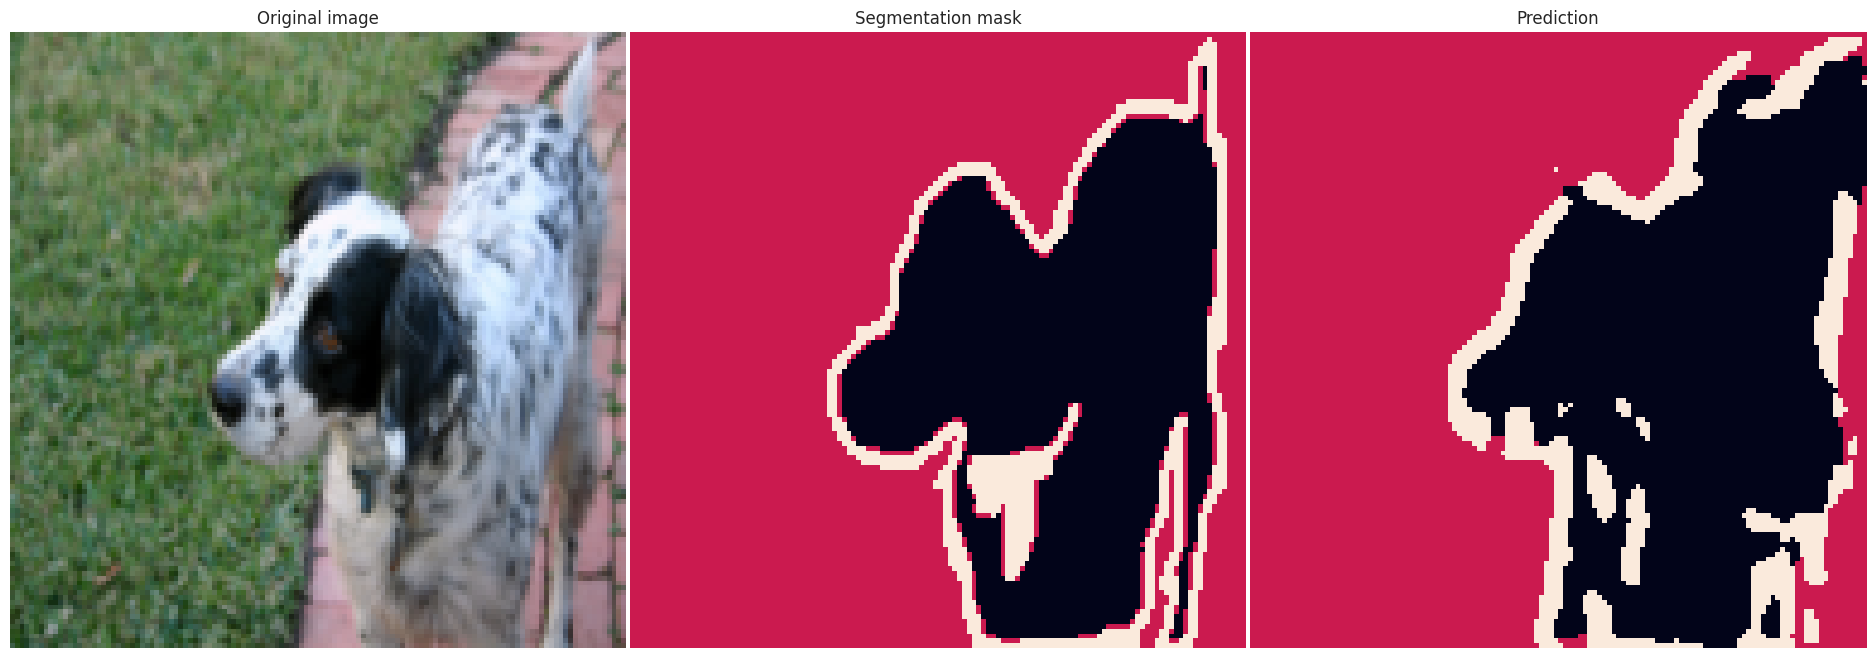

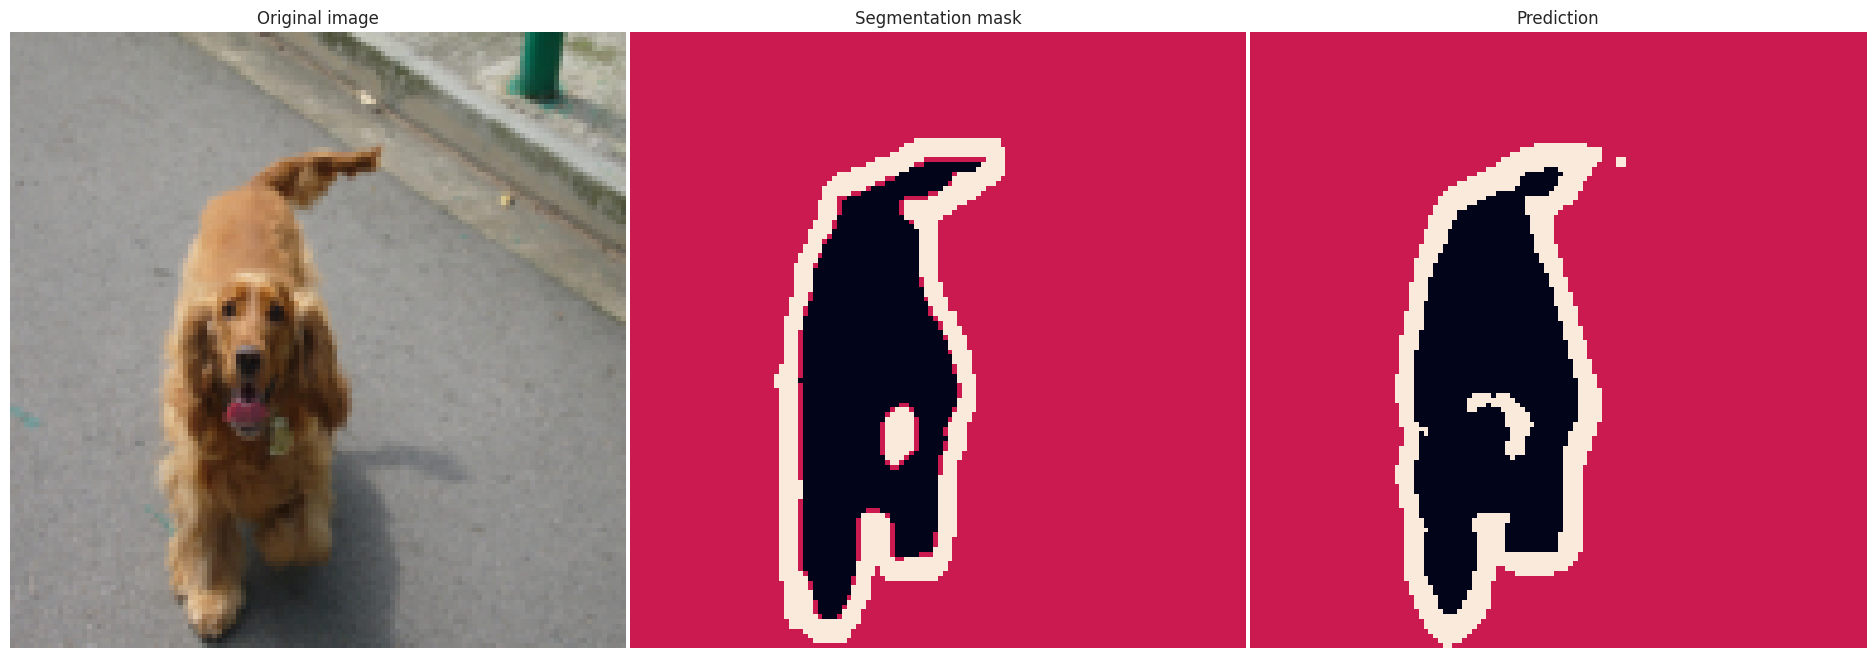

In [ ]:
visualize(model, next(iter(train_loader)), device)
# Визуализация результатов